In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime as dt
import numpy as np
import fnmatch
import os

Page views time series.
===
Log scale makes local peaks more visible. Linear scale plots are in plots/pageviews if you want to see them.

In [56]:
def plotPageViews(df, articleName, language):
    '''
    Plot page views log scale
    ---
    Parameters:
    df:           the dataframe, loaded from "wiki_<lang>_pageviews_<dates>.csv" file
    articleName:  the WHOLE name of the article of interest, in English
    '''
    # color code
    if "conflict" in articleName:
        clr = "gray"
    elif "Article" in articleName:
        clr = "green"
    elif "Insurgency" in articleName:
        clr = "mediumvioletred"
    
    # subset dataframe
    df = df[df['article'] == articleName]
    df['ts'] = pd.to_datetime(df['date'])
    df = df.drop('date', axis=1)
    
    # plot log scale page-views vs time
    df['views'].plot(linestyle='-', linewidth=1.5, color = clr)
    plt.yscale('log')
    plt.title(language + " " + articleName + " Pageviews per day log scale")
    
    
def pageViewsFname(lang):
    '''
    Quick helper that returns the name of the file that contains pageviews data for a given language.
    This will need to change when we get new data (*TODO*)
    '''
    return "wiki_" + lang + "_pageviews_2000_thru_Dec2019.csv"

/home/molly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


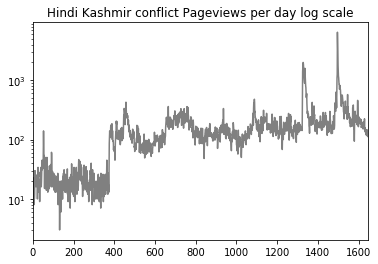

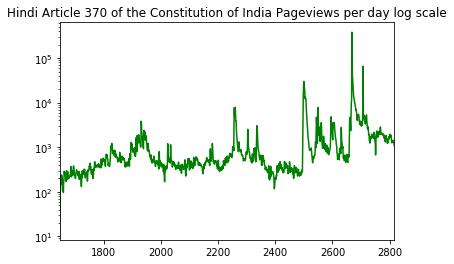

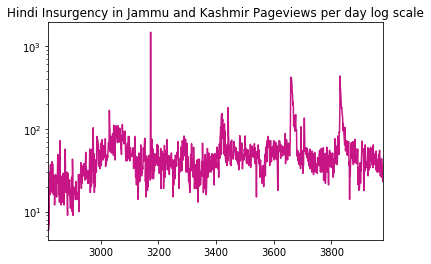

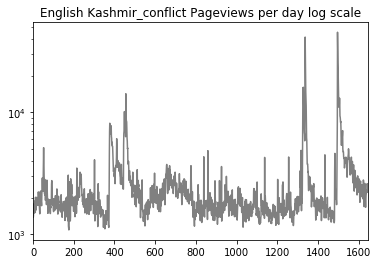

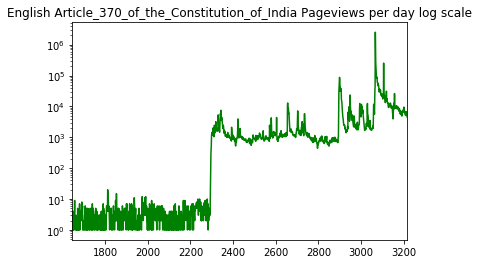

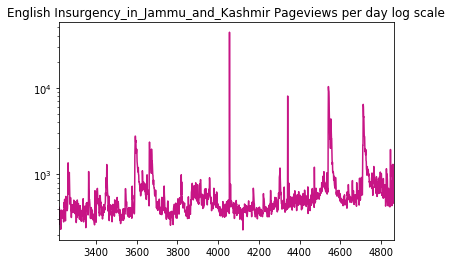

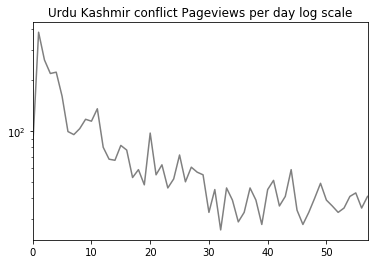

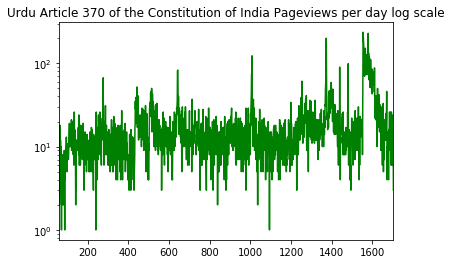

In [57]:
for filepair in [(pageViewsFname("hindi"), "Hindi"), (pageViewsFname("english"), "English"),\
                 (pageViewsFname("urdu"), "Urdu")]:
    
    pvdf = pd.read_csv(filepair[0])
    #print(pvdf.head())
    articlesList = ["Kashmir conflict", "Article 370 of the Constitution of India",\
                    "Insurgency in Jammu and Kashmir", "Insurgency in Jammu and Kashmir", "/"]
    
    for article in articlesList:
        
        if (filepair[1] == "Urdu") &  ("Insurgency" in article):
            continue
        
        if filepair[1] == "English":
            plotPageViews(pvdf, article.replace(" ", "_"), filepair[1])
        else:
            plotPageViews(pvdf, article, filepair[1])
        plt.show()


In [11]:
def findfile(prefix):
    '''
    This is for finding the file you want, no matter the date in the filename
    Assumes the folder has only the most recent files in it
    '''
    for f in os.listdir(mypath):
        if fnmatch.fnmatch(f, prefix + '_*.json'):
            return f

In [14]:
# Helper function for time-lagged cross-correlation (how we measure editing response time)

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """ 
    return datax.corr(datay.shift(lag))


In [15]:
def corrPlot(views, edits, what):
    '''
    TIME-LAGGED CROSS-CORRELATION
    -2 week to 2 week lag
    Correlation computed between views per day and edits per day
    We "know" that edits don't lead pageviews, so in a perfect world there would be no correlation to the right of
    center. Interesting results to follow!
    '''
    rs = [crosscorr(views, edits, lag) for lag in range(int(-14),int(15))]
    # Offset tells what lag yielded peak synchrony (positive = views led; negative = edits led)
    offset = np.floor(len(rs)/2)-np.argmax(rs)
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs)
    ax.axvline(np.floor(len(rs)/2),color='k',linestyle='--',label='Center')
    ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
    ax.set(title=f'Offset = {offset} days\nviews leads <> edits leads',ylim=[0,1],xlim=[0,28], xlabel='Offset',\
           ylabel='Pearson r')
    # TICKS are -14 to 14: the offsets we set
    ax.set_xticks([0, 7, 14, 21, 28])
    ax.set_xticklabels([-14, -7, 0, 7, 14]);
    plt.suptitle(what + " correlation between pageviews and edits", y=1.1)
    plt.legend()
    

def getEdits(filepath):
    '''
    Get edits dataframe given filepath. File must be json.
    '''
    with open(filepath) as thefile:
            data = json.load(thefile)
            dfEdits = pd.DataFrame(data)

    dfEdits['timestamp'] = pd.to_datetime(dfEdits['timestamp'])
    dfEdits = dfEdits.set_index('timestamp')
    dfEdits = dfEdits.groupby(pd.Grouper(freq='D', level=0)).count()

    # pandas timezone weirdness requires that we do this
    dfEdits.index = dfEdits.index.date

    # total edits = edits by registered users + "anonymous" edits (IP addresses and people who wish to remain anon)
    if 'anon' in dfEdits.columns:
        dfEdits['total'] = dfEdits['user'] + dfEdits['anon']
    else: # Pulwama Urdu (and maybe others) don't have the anon field
        dfEdits['total'] = dfEdits['user']
    
    return dfEdits


def getViews(filepath, article):
    '''
    Get pageviews dataframe given filepath. File must be csv.
    '''
    df = pd.read_csv(filepath)
    df = df[df['article'] == article]

    df['ts'] = pd.to_datetime(df['date'])
    df = df.drop('date', axis=1)
    df = df.set_index('ts')
    
    return df

Edits per day timeseries
===

The original three articles:
* Kashmir Conflict
* Article 370 of the Constitution of India
* Insurgency in Jammu and Kashmir

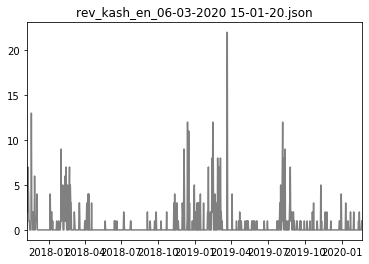

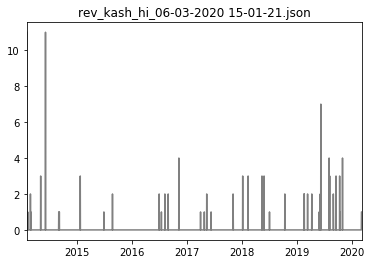

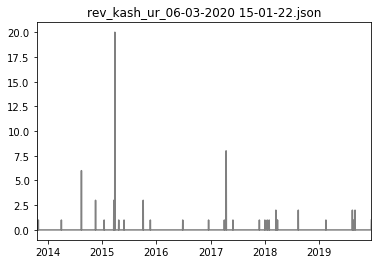

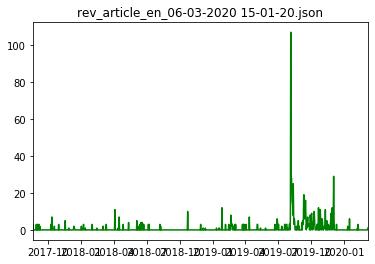

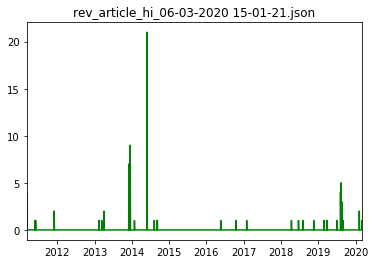

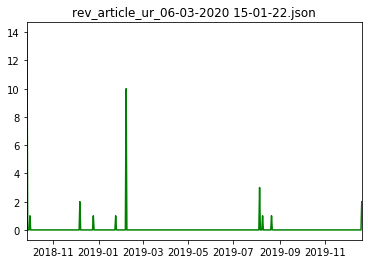

            user  size  comment  total
2012-08-13     1     1        1      1
2012-08-14     0     0        0      0
2012-08-15     0     0        0      0
2012-08-16     0     0        0      0
2012-08-17     0     0        0      0


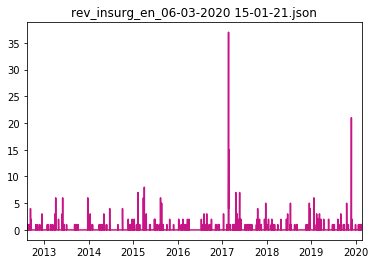

            user  size  comment  anon  total
2011-04-14     1     1        1     0      1
2011-04-15     0     0        0     0      0
2011-04-16     0     0        0     0      0
2011-04-17     0     0        0     0      0
2011-04-18     0     0        0     0      0


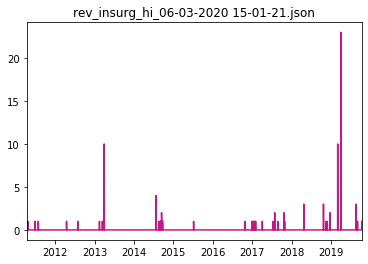

In [58]:
# THE OG ARTICLES

mypath = "../data/revisions/" # Do Not Change This

for file in [findfile("rev_kash_en"), findfile("rev_kash_hi"), findfile("rev_kash_ur")]:
        edits = getEdits(mypath + file)
        edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color="gray")
        plt.show()
        
for file in [findfile("rev_article_en"), findfile("rev_article_hi"), findfile("rev_article_ur")]:
        edits = getEdits(mypath + file)
        edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color="green")
        plt.show()
        
for file in [findfile("rev_insurg_en"), findfile("rev_insurg_hi")]:
        edits = getEdits(mypath + file)
        print(edits.head())
        edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color="mediumvioletred")
        plt.show()

**``Pulwama Attack 2019"** pages

            user  size  comment  anon  total
2019-02-15    29    29       29     0     29
2019-02-16    46    46       46     0     46
2019-02-17   106   106      106     0    106
2019-02-18    67    67       67    10     77
2019-02-19    35    35       35     0     35


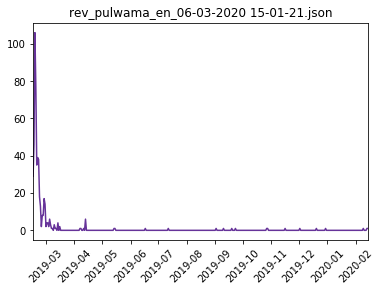

            user  anon  size  comment  total
2019-02-15    27     0    27       27     27
2019-02-16     5     0     5        5      5
2019-02-17     7     3     7        7     10
2019-02-18     1     0     1        1      1
2019-02-19     0     0     0        0      0


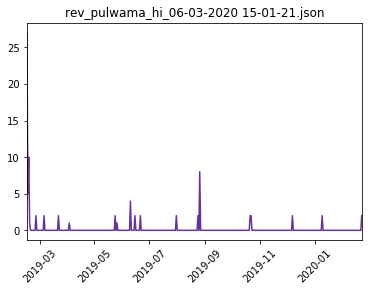

            user  size  comment  total
2019-02-15    12    12       12     12
2019-02-16    55    55       55     55
2019-02-17     4     4        4      4
2019-02-18     5     5        5      5
2019-02-19     0     0        0      0


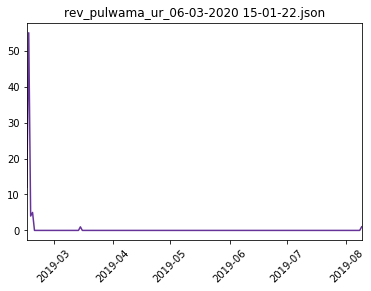

In [55]:
# PULWAMA EDITS

for file in [findfile("rev_pulwama_en"), findfile("rev_pulwama_hi"),
             findfile("rev_pulwama_ur")]:
        edits = getEdits(mypath + file)
        print(edits.head())
        edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color='rebeccapurple')
        plt.xticks(rotation=45) 
        plt.show()

**``Reorganization of Jammu & Kashmir"** pages

            user  size  comment  anon  total
2019-08-06    36    36       36     1     37
2019-08-07    26    26       26     6     32
2019-08-08     8     8        8     0      8
            user  size  comment  anon  total
2020-03-03     0     0        0     0      0
2020-03-04     0     0        0     0      0
2020-03-05     2     2        2     0      2


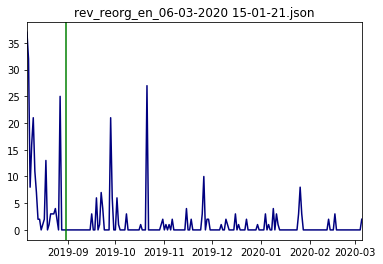

            user  size  comment  total
2019-08-07     8     8        8      8
2019-08-08     1     1        1      1
2019-08-09    47    47       47     47
            user  size  comment  total
2019-08-22     0     0        0      0
2019-08-23     0     0        0      0
2019-08-24     1     1        1      1


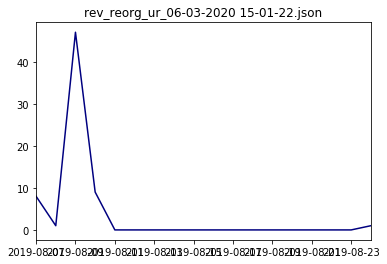

            user  size  comment  anon  total
2019-08-07     4     4        4     0      4
2019-08-08     0     0        0     0      0
2019-08-09     0     0        0     0      0
            user  size  comment  anon  total
2020-02-24     0     0        0     0      0
2020-02-25     0     0        0     0      0
2020-02-26     1     1        1     0      1


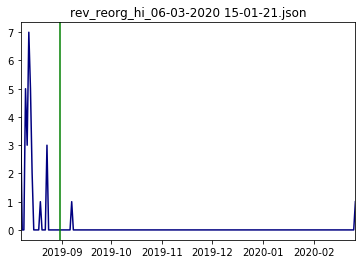

In [51]:
# REORGANISATION EDITS

for file in [findfile("rev_reorg_en"), findfile("rev_reorg_ur"), findfile("rev_reorg_hi")]:
    fig, ax = plt.subplots()
    edits = getEdits(mypath + file)
    print(edits.head(3))
    print(edits.tail(3))
    edits['total'].plot(linestyle='-', linewidth=1.5, title=file, color='navy')
    ax.axvline(dt.datetime(2019,8,31), color='g') # vertical line cuz this is the day we sampled text from
    plt.show()

In [22]:
for f in os.listdir(mypath):
    if fnmatch.fnmatch(f, 'rev_article_en_*.json'):
        file = f
articleEnPath = "../data/revisions/" + file
    
dfEdits = getEdits(articleEnPath)

dfEdits.tail()

,user,size,comment,anon,total
2020-03-02,0,0,0,0,0
2020-03-03,0,0,0,0,0
2020-03-04,0,0,0,0,0
2020-03-05,0,0,0,0,0
2020-03-06,1,1,1,0,1


Time-lagged Cross-correlation (TLCC) on each *``Kashmir Conflict"* page
===
Did not use these data in the paper, only ``Article 370" --- Kashmir conflict edits don't correlate significantly with views

* English ``Kashmir Conflict" page

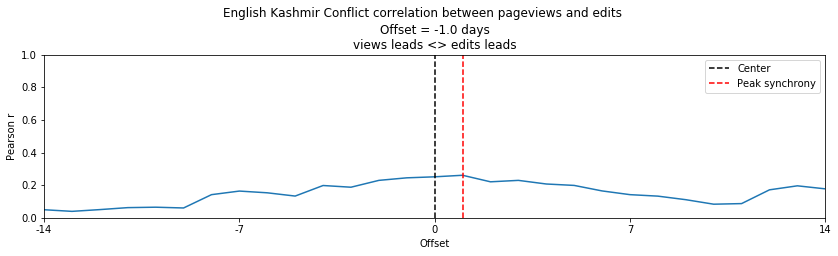

In [23]:
# Kashmir Conflict

# English

for f in os.listdir(mypath):
    if fnmatch.fnmatch(f, 'rev_kash_en_*.json'):
        file = f

views = getViews("wiki_english_pageviews_2000_thru_Dec2019.csv", "Kashmir_conflict")
edits = getEdits("../data/revisions/" + file)

corrPlot(views['views'], edits['total'], "English Kashmir Conflict")

#views.head()

* Hindi ``Kashmir Conflict" page

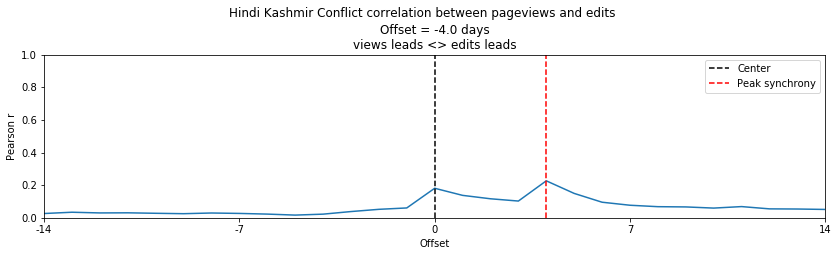

In [24]:
# Hindi

for f in os.listdir(mypath):
    if fnmatch.fnmatch(f, 'rev_kash_hi_*.json'):
        file = f

views = getViews("wiki_hindi_pageviews_2000_thru_Dec2019.csv", "Kashmir conflict")
edits = getEdits("../data/revisions/" + file)
corrPlot(views['views'], edits['total'], "Hindi Kashmir Conflict")

* Urdu ``Kashmir Conflict" page

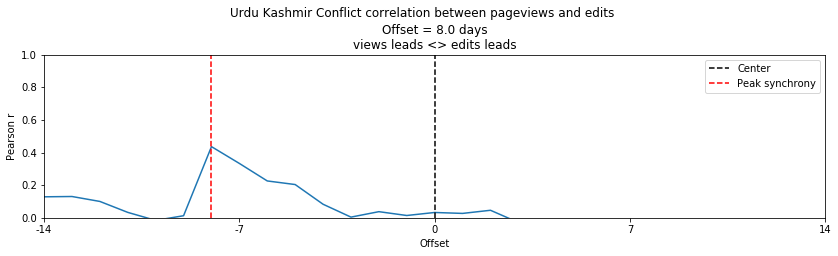

In [25]:
# Urdu

for f in os.listdir(mypath):
    if fnmatch.fnmatch(f, 'rev_kash_ur_*.json'):
        file = f

views = getViews("wiki_urdu_pageviews_2000_thru_Dec2019.csv", "Kashmir conflict")
edits = getEdits("../data/revisions/" + file)
corrPlot(views['views'], edits['total'], "Urdu Kashmir Conflict")

In [26]:
del edits
del views

TLCC plots overlaid for *``Article 370"*
===

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


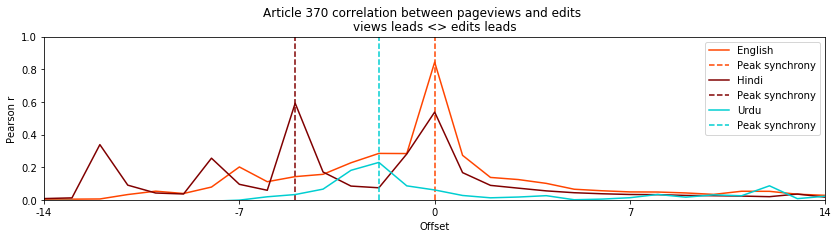

In [27]:
def corrPlotOverlay(articleName, views, edits, viewsH, editsH, viewsU, editsU):
    '''
    TIME-LAGGED CROSS-CORRELATION
    -2 week to 2 week lag
    Correlation computed between views per day and edits per day
    We "know" that edits don't lead pageviews, so in a perfect world there would be no correlation to the right of
    center. Interesting results to follow!
    '''
    color = 'orangered'
    
    r = []
    l = []
    d = []
        
    rs = [crosscorr(views, edits, lag) for lag in range(int(-14),int(15))]
    for pearson in rs:
        r.append(pearson)
        l.append('en')
    for lag in range(int(-14),int(15)):
        d.append(lag)
    f,ax=plt.subplots(figsize=(14,3))
    
    # Offset tells what lag yielded peak synchrony (positive = views led; negative = edits led)
    ax.plot(rs, color=color, label='English')
    ax.axvline(np.argmax(rs),color=color,linestyle='--',label='Peak synchrony')
    ax.set(title='views leads <> edits leads',ylim=[0,1],xlim=[0,28], xlabel='Offset',ylabel='Pearson r')
    # TICKS are -14 to 14: the offsets we set
    ax.set_xticks([0, 7, 14, 21, 28])
    ax.set_xticklabels([-14, -7, 0, 7, 14]);
    
    # Second set
    color = 'maroon'
    rs = [crosscorr(viewsH, editsH, lag) for lag in range(int(-14),int(15))]
    for pearson in rs:
        r.append(pearson)
        l.append('hi')
    for lag in range(int(-14),int(15)):
        d.append(lag)
    # Offset tells what lag yielded peak synchrony (positive = views led; negative = edits led)
    offset = np.floor(len(rs)/2)-np.argmax(rs)
    ax.plot(rs, color=color, label='Hindi')
    ax.axvline(np.argmax(rs),color=color,linestyle='--',label='Peak synchrony')
    
    # Third set
    color = 'darkturquoise'
    rs = [crosscorr(viewsU, editsU, lag) for lag in range(int(-14),int(15))]
    for pearson in rs:
        r.append(pearson)
        l.append('ur')
    for lag in range(int(-14),int(15)):
        d.append(lag)
    # Offset tells what lag yielded peak synchrony (positive = views led; negative = edits led)
    offset = np.floor(len(rs)/2)-np.argmax(rs)
    ax.plot(rs, color=color, label='Urdu')
    ax.axvline(np.argmax(rs),color=color,linestyle='--',label='Peak synchrony')
        
    plt.suptitle(articleName + " correlation between pageviews and edits", y=1.02)
    plt.legend()
    
    d = {'lang': l, 'pearson': r, 'offset': d}
    df = pd.DataFrame(data=d)
    return df

        
viewsEn = getViews("wiki_english_pageviews_2000_thru_Dec2019.csv", "Article_370_of_the_Constitution_of_India")
editsEn = getEdits("../data/revisions/" + findfile("rev_article_en"))

viewsHi = getViews("wiki_hindi_pageviews_2000_thru_Dec2019.csv", "Article 370 of the Constitution of India")
editsHi = getEdits("../data/revisions/" + findfile("rev_article_hi"))

viewsUr = getViews("wiki_urdu_pageviews_2000_thru_Dec2019.csv", "Article 370 of the Constitution of India")
editsUr = getEdits("../data/revisions/" + findfile("rev_article_ur"))

# save the Pearson correlation data to CSV
pearson_df = corrPlotOverlay("Article 370", viewsEn['views'], editsEn['total'], viewsHi['views'], \
                             editsHi['total'], viewsUr['views'], editsUr['total'])
pearson_df.to_csv("pearson_corr_article_370.csv", index=False)

# save the figure
plt.savefig("views_edits_article370_corr.eps")

Plots of views vs edits, with significant events, for **``Article 370"** --- could do this for all articles easily

In [31]:
def tsViewsEdits(views, edits, lang):
    '''
    Just want plot with two time series: edits and views. One call to this fun per language
    '''
    views = views[dt.date(2019,1,1):dt.date(2019,12,1)]# temporary...
    edits = edits[dt.date(2019,1,1):dt.date(2019,12,1)]# temporary...
    # Views
    fig,ax = plt.subplots()
    plt.yscale('log')
    color = "k"
    l1 = ax.plot(views.index, views.views, color=color)
    ax.set_ylabel("Page-views per day", color=color)
    # Edits    
    ax2 = ax.twinx()
    color="tab:orange"
    l2 = ax2.plot(edits.index, edits.total, color=color)
    ax2.set_ylabel("Edits per day", color=color)
    #plt.show()
    l3 = ax.axvline(x=dt.date(2019,2,14), color='b',linestyle='--', label='Pulwama Attack')
    l4 = ax.axvline(x=dt.date(2019,8,5), color='c', linestyle='--', label='Revocation of Article 370')
    
    if lang != "urdu":
        ax.legend()
        #ax2.legend()
    
    plt.savefig("views_edits_article370_ts_"+lang+".eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


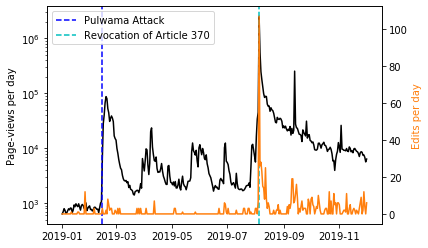

In [32]:
editsEn2 = editsEn

editsEn2.set_index(pd.to_datetime(editsEn2.index))

tsViewsEdits(viewsEn, editsEn2, "english")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


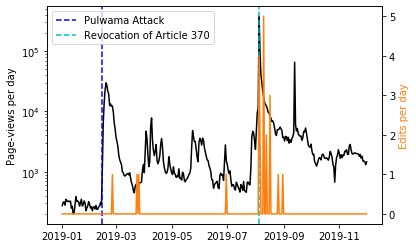

In [29]:
editsHi2 = editsHi

editsHi2.set_index(pd.to_datetime(editsHi2.index))

tsViewsEdits(viewsHi, editsHi2, "hindi")

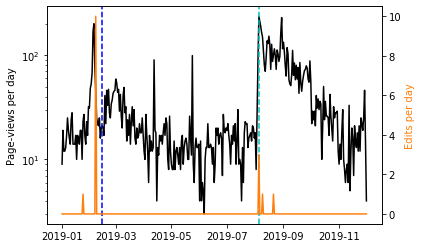

In [33]:
editsUr2 = editsUr

editsUr2.set_index(pd.to_datetime(editsUr2.index))

tsViewsEdits(viewsUr, editsUr2, "urdu")